## Lab #1 - Sandbox notebook for the use case: Courier default

Let's assume we are all data-scientists, and we are currently working on the exploration and development of our models for solving the courier default use case.

-------

**Courier default description:**

*"We define courier default when a courier collects a high amount of cash and then leaves the company without returning the money.

- By leaving the company we define as not having any interaction with Glovo during 28 consecutive days since the last delivered order.
- Each region/city/country has a threshold to designate a high amount of cash defined by the business.

The business request made to the Data Science team is to design a machine learning system to detect when a courier is likely to incur in default before they actually default or before the amount of cash balance is too high.

The proposed definition is to deliver a default score for each courier every week. For that we created a label for each courier on a window time, so we can identify some defaulters and then fit a xgboost classifier to predict on current couriers."*

-------

In this notebook we will explore different methods for working with this binary classification use case based on XGBoost, in order to predict the default or not default condition for the couriers.

Let's try with these approaches:

1. We will load the existing XGBoost model file (trained outside of AWS), and analyse it with open-source XGBoost.
2. We will repeat the analysis levaraging on Amazon SageMaker Autopilot for using AutoML.
3. Finally, we will repeat the step 1 but leveraging on Amazon SageMaker built-in XGBoost algorithm, and we will use the hyperparameters from step 2.

#### Importing relevant packages...

Let's start by loading some relevant libraries.

In [2]:
## Importing relevant packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import datetime as dt
import pickle as pkl
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

import sagemaker
import boto3
from sagemaker.predictor import csv_serializer
from sagemaker import get_execution_role

### 1. Working with the existing model

Let's work with the dataset provided, and perform the same feature selection done as per the use case description.


In [252]:
## Read data

import xgboost as xgb
import json
from sklearn.model_selection import train_test_split

data = pd.read_csv('joint_dataframe.csv')

data.head(5)

,courier_id,churn_last_month,registration_date,last_order_time,first_order_time,country_code,city_code,balance_at_that_day_eur,threshold_old,is_defaulter,...,courier__orders_slot_last_7days_over_city_avg_ratio,courier__daily_no_shows_slots_avg_last_week,courier__daily_no_shows_to_booked_slots_ratio_first_week,courier__latenight_slots_booked_count_first_month,courier__delivered_orders_that_belong_to_stores_with_cash_acceptance,courier__credit_acceptance_stores_cancelled_orders,city__stores_with_cash_acceptance_ratio,courier__delivered_orders_that_belong_to_stores_with_credit_acceptance,courier__cash_acceptance_stores_cancelled_orders,courier__assigned_cash_acceptance_store_ratio
0,115561,0,2016-06-10 13:50:12,2020-07-24 09:38:24,2016-06-11 09:23:46,IT,MIL,26.0,179.655,0,...,1.0625,0.0,0.0,2.0,4957.0,257.0,0.839444,8513.0,1202.0,0.540659
1,481059,0,2017-05-05 17:46:36,2020-07-24 11:33:33,2017-05-06 19:39:14,ES,SEV,100.0,181.965,0,...,1.1333,0.0,0.0,0.0,4183.0,204.0,0.328922,9187.0,824.0,0.446024
2,512784,0,2017-05-22 15:28:20,2020-07-24 11:49:24,2017-05-25 10:04:50,IT,MIL,42.0,179.655,0,...,1.5000,0.0,0.0,0.0,5681.0,135.0,0.839444,8593.0,564.0,0.646496
3,601705,0,2017-06-22 15:29:58,2020-07-24 11:37:21,2017-06-25 10:02:10,IT,MIL,106.0,179.655,0,...,1.1250,0.0,0.0,0.0,1292.0,44.0,0.839444,2828.0,49.0,0.447927
4,623940,0,2017-06-29 07:54:01,2020-06-27 21:39:40,2017-07-02 10:18:59,IT,MIL,42.0,179.655,0,...,0.9375,0.0,0.0,0.0,2619.0,83.0,0.839444,4223.0,482.0,0.625691


In [253]:
### Store the target feature in a separate dataframe

y_data = data['is_defaulter']
print(y_data.shape)

(37766,)


In [254]:
### Drop some features as per the use case description

cols = [0, 1, 2, 3, 4, 5, 6, 8, 9, 56, 191, 201, 203, 206, 209, 218, 220]
data.drop(data.columns[cols],axis=1,inplace=True)
data.head(5)

,balance_at_that_day_eur,courier__customers_orders_positive_rating_count,couriers__customers_positive_rating_ratio,courier_paying_cash_customers_per_country_ratio_last_month,courier__order_rating_max,courier__cash_paying_customers_ratio_first_to_last_week,courier__cash_paying_customers_ratio_last_month,courier__customers_negative_rating_per_country_ratio,courier_paying_cash_customers_per_country_ratio,courier__customers_positive_to_negative_rating_per_country_ratio,...,courier__orders_slot_last_7days_over_city_avg_ratio,courier__daily_no_shows_slots_avg_last_week,courier__daily_no_shows_to_booked_slots_ratio_first_week,courier__latenight_slots_booked_count_first_month,courier__delivered_orders_that_belong_to_stores_with_cash_acceptance,courier__credit_acceptance_stores_cancelled_orders,city__stores_with_cash_acceptance_ratio,courier__delivered_orders_that_belong_to_stores_with_credit_acceptance,courier__cash_acceptance_stores_cancelled_orders,courier__assigned_cash_acceptance_store_ratio
0,26.0,2387.0,0.97,0.13,5.0,0.0,0.16,0.75,1.29,1.42,...,1.0625,0.0,0.0,2.0,4957.0,257.0,0.839444,8513.0,1202.0,0.540659
1,100.0,2856.0,0.99,0.11,5.0,0.0,0.13,0.33,10.29,2.49,...,1.1333,0.0,0.0,0.0,4183.0,204.0,0.328922,9187.0,824.0,0.446024
2,42.0,3969.0,0.98,0.10,5.0,0.0,0.13,0.50,1.87,2.24,...,1.5000,0.0,0.0,0.0,5681.0,135.0,0.839444,8593.0,564.0,0.646496
3,106.0,1112.0,0.99,0.07,5.0,0.0,0.10,0.25,0.45,4.03,...,1.1250,0.0,0.0,0.0,1292.0,44.0,0.839444,2828.0,49.0,0.447927
4,42.0,2028.0,0.95,0.07,5.0,0.0,0.21,1.25,0.99,0.76,...,0.9375,0.0,0.0,0.0,2619.0,83.0,0.839444,4223.0,482.0,0.625691


In [136]:
### Split the dataset in train/test, and convert the dataframes to XGBoost matrixes

X = data.values
Y = y_data.values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

D_train = xgb.DMatrix(X_train, label=Y_train)
D_test = xgb.DMatrix(X_test, label=Y_test)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(28324, 323)
(28324,)
(9442, 323)
(9442,)


Now, let's load the existing model trained outside AWS.

In [137]:
## Load existing model

model = pkl.load(open("model-sav", "rb"))
type(model)


xgboost.sklearn.XGBClassifier

Let's run predictions over the testing dataset, and evaluate some model metrics.

In [138]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

preds = model.predict(X_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(Y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(Y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(Y_test, best_preds)))


Precision = 0.48035373861470027
Recall = 0.5
Accuracy = 0.9607074772294005


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The model seems to have decent accuracy but the precision and recall seems to be low.

Let's confirm the confusion matrix to understand how much false negatives and false positives we are having.

In [221]:
cm = confusion_matrix(Y_test, (preds>0.5))
print('The Confusion Matrix is: \n', cm)
print('TrueNegative   FalsePositive\nFalseNegative   TruePositive\n')

# Calculate the accuracy on test set
predict_accuracy_on_test_set = (cm[0,0] + cm[1,1])/(cm[0,0] + cm[1,1]+cm[1,0] + cm[0,1])
print('The Accuracy on Test Set is: ', predict_accuracy_on_test_set)

The Confusion Matrix is: 
 [[9070    1]
 [ 369    2]]
TrueNegative   FalsePositive
FalseNegative   TruePositive

The Accuracy on Test Set is:  0.9608133869942809


In [226]:
print("Indices where is_defaulter should be one: ", np.nonzero(Y_test > 0))
print("\nIndices where is_defaulter is one: ", np.nonzero(preds > 0))

print("\n------- False negative case: -------")
print("Defaulter data: \n", list(X_test[3][:]))
print("The true is_defaulter value: ", Y_test[3], " the predicted is_defaulter value: ", preds[3])
sample = [60.11, 110.0, 0.99, 0.09, 5.0, 0.77, 0.44, 0.5, 0.36, 2.29, 0.01, 48.0, 0.02, 1.0, 110.0, 0.64, 1.01, 0.71, 0.00495662949194547, 4.0, 0.02, 0.98, 807.0, 1.0, 4.0, 111.0, 1.33, 0.44, 0.0, 5.0, 11.0, 0.5128205128205128, 0.0, 39.0, 2.0, 0.18181818181818185, 0.0924170616113744, 0.0196078431372549, 0.07471264367816091, 39.0, 1.0, 0.0, 0.0, 0.8478260869565217, 0.96, 0.38, 31.43, 0.05, 62.46, 3.21252782376189, 60.11, 2.0, 0.7, 37.0, 1.297491039426523, 47.0, 213.0, 38.0, 753.0, 1.027027027027027, 181.0, 0.7926315789473685, 0.5046480743691899, 1.0734463276836157, 0.5498007968127491, 147.0, 0.668086239020495, 414.0, 0.694555112881806, 1.2312925170068028, 523.0, 0.8497652582159625, 10.02, 0.46, 10.43, 1172.27, 189.4, 0.0, 2.3, 0.0, 2196.57, 1.0, 0.0, 0.04, 211355.43, 84.48, 1.91, 0.0, 59.3, 0.0, 1.03, 0.7, 0.01, 0.02, 298.17, 0.689604842322592, 0.0, 227.86, 0.0, 52.07, 1.94, 0.02, 0.9, 395913.79, 0.31, 0.0, 1.28, 12.71, 83.74, 765.42, 0.1, 579.95, 0.01, 1.0, 8604.43, 130.06, 0.54, 70.1718644837339, 0.0, 0.0, 0.0, 0.56, 24.0, 9.0, 0.66, 0.0, 0.0, 19.0, 127.230466482265, 85.90011414995679, 55.0, 0.16, 1.07, 0.0, 71.6590049396513, 0.26, 0.0, 42.08, 0.0, 0.0, 37.45, 0.0, 1.08, 0.0, 10.0, 37.96, 90.0, 0.0, 19.0, 0.0, 55.0, 0.5, 28.0, 0.37, 0.0, 0.31, 40.0, 90.0, 0.16, 40.45, 38.0, 27.0, 173.0, 0.0, 178.0, 0.41, 0.24, 0.0, 0.49, 0.0, 0.0, 0.51, 46.57, 28.0, 0.32, 0.0, 0.0, 90.8904313776849, 0.52, 0.93, 1.0, 7.0, 0.0, 36.9236331328595, 0.0, 825.0, 0.0, 1.0, 1.0, 0.0, 1.53846153846154, 26.23, 0.0, 2.4935483870967703, 0.0, 6.125, 27.0, 753.0, 7.0, 83.0, 0.0, 1.5609320122090802, 21.6833, 310.0, 0.46524609707560494, 143.92, 13.0, 0.0, 0.91, 0.24, 21.0, 380.0, 1.65, 1.77, 80.0, 5.0, 41.0, 0.45, 0.45, 36.0, 0.89, 57.4, 0.41, 0.57, 0.1192, 0.94113029827315, 232.33333333333331, 23.98, 0.0784, 10.5, 11.08, 0.8849926199200001, 0.78, 28.5, 6.97, 27.37, 27.2, 0.0491, 0.39, 0.1769, 2.87, 0.022370486656200003, 0.4, 0.73, 0.57, 24.33333333333333, 28.0, 0.15, 0.71, 12.0, 18.0, 12.0, 2.33, 9.0, 0.13, 0.74, 100000.0, 0.0, 1.77, 0.13, 0.22, 0.0, 0.3193277310924369, 950.0, 0.0, 0.2689075630252101, 0.0, 0.9, 0.22, 10.0, 0.56, 0.6956, 10000.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5384, 689.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.54, 0.0, 10000.0, 0.0, 4.0, 1.54, 1.0, 0.8571, 0.0, 1.0, 0.0, 1.4, 1.54, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.2, 0.0, 0.0, 1.0, 360.0, 24.0, 0.8343309106455751, 288.0, 48.0, 0.8379373848987108]
pred = model.predict(sample)
print(pred)

print("\n------- False positive case: -------")
print("Defaulter data: \n", list(X_test[1886][:]))
print("The true is_defaulter value: ", Y_test[1886], " the predicted is_defaulter value: ", preds[1886])
sample = [184.0, 2900.0, 0.98, 0.39, 5.0, 0.0, 0.51, 0.5, 4.21, 1.78, 0.02, 23.0, 0.12, 71.0, 40.85, 0.65, 1.02, 0.0, 0.00825206301575393, 4.0, 0.04, 0.96, 3999.0, 1.0, 33.0, 2971.0, 0.0, 0.58, 7.142857142857142, 1.0, 3.0, 6.7857142857142865, 5.0, 180.0, 19.0, 6.333333333333332, 0.03443657929978955, 0.04231625835189309, 0.030349013657056136, 127.0, 0.7055555555555556, 5.0, 0.04273504273504273, 6.143344709897611, 0.07, 1.89, 145.4, 0.77, 2599.0, 1038.0, 184.0, 12.0, 0.49, 20.0, 4.235171696149844, 110.0, 443.0, 99.0, 5422.0, 4.95, 407.0, 0.9366039039557782, 0.2816303946883069, 3.928571428571429, 0.3865732202139432, 132.0, 7.147376746638543, 2096.0, 0.6099225378089266, 3.083333333333333, 3307.0, 0.9187358916478556, 7.12, 4.54, 17.06, 4781.02, 438.94, 0.0, 1.45, 0.0, 22482.46, 1.0, 0.89, 0.0, 263691.34, 277.56, 0.92, 0.0, 339.35, 3.9586415365578294e-05, 3.4, 1.22, 0.0, 0.0, 1015.04, 0.0, 0.0, 379.52, 0.0, 0.0, 0.32, 0.0, 7.12, 1077023.92, 0.77, 0.0, 3.31, 0.0, 1225.2, 0.0, 0.02, 436.29, 0.0, 0.0, 95907.23, 74.76, 0.59, 41.322943430657, np.nan, 0.0, np.nan, 0.72, np.nan, np.nan, 0.82, 0.0, 0.0, np.nan, 60.1107199324761, 50.785041042695, np.nan, 0.0, 1.42, np.nan, 48.1914191364083, 0.0, 0.0, 32.95, 0.0, 0.0, 25.9, 0.0, 0.89, 0.0, np.nan, 24.37, np.nan, 0.0, np.nan, np.nan, np.nan, 0.0, np.nan, 0.57, np.nan, 0.0, np.nan, np.nan, 0.0, 34.5, np.nan, np.nan, np.nan, np.nan, np.nan, 0.52, 0.0, np.nan, 0.65, 0.0, np.nan, 0.0, 34.03, np.nan, 0.0, 0.0, 0.0, 49.9810437910087, 0.0, 1.05, 0.0, 1.0, 0.0, 100.0, 0.0, 5622.0, 0.0, 1.0, 1.0, 3.0, 1.35, 18.46, 0.0, 10.0, 0.0, 35.0, 50.0, 5422.0, 1.0, 10.0, 0.0, 1.2351362605839098, 35.3166, 9.0, 1.0377370041887801, 4.94, 83.0, 20.0, 4.65, 0.0, 0.0, 1527.0, 0.0, 0.0, 0.0, 37.0, 12.0, 4.44, 0.0, 136.0, 6.45, 18.15, 0.52, 0.35, 1.005, 0.86319050077439, 234.0, 16.72, 0.5118, 12.99, 12.68, 1.1144399999999999, 0.18, 16.6, 7.02, 21.89, 17.81, 0.6659999999999999, 0.73, 0.602, 3.63, 0.018069179143000002, 0.58, 4.6, 0.83, 153.33333333333334, 13.0, 0.02, 6.76, 0.0, 3.0, 196.0, 130000.0, 127.0, 0.03, 0.52, 30000.0, 0.0, 0.7, 0.03, 0.03, 0.0, 0.14545454545454545, 5789.0, 0.0, 0.2545454545454545, 0.0, 0.0, 0.1, 3.0, 0.6521, 0.8571, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 10000.0, 1.0, 1.0, 10000.0, 0.84, 0.0, 1.0, 0.0, 1.0, 1.5384, 3909.0, 33.33, 1.0, 0.0, 8.33, 0.0, 0.0, 5.56, 0.0, 0.0, 7.0, 0.0, 0.0, 1.1538, 0.0, 2.0, 10000.0, 1.5, 4.88, 0.0, 1.0, 0.14, 0.0, 0.0, 0.0, 1.2857, 0.0, 10000.0, 0.0, 2092.0, 141.0, 0.9225806451612903, 4995.0, 126.0, 0.41353248155479577]
pred = model.predict(sample)
print(pred)

Indices where is_defaulter should be one:  (array([   3,   46,   67,  100,  106,  111,  116,  162,  164,  206,  223,
        253,  261,  298,  309,  315,  318,  355,  393,  398,  444,  495,
        508,  532,  540,  574,  603,  645,  650,  686,  743,  749,  768,
        793,  835,  848,  871,  881,  897,  904,  924,  925,  933,  944,
        955,  973,  974,  980,  991, 1007, 1075, 1105, 1112, 1114, 1160,
       1179, 1194, 1198, 1213, 1232, 1234, 1247, 1248, 1281, 1291, 1343,
       1426, 1450, 1509, 1547, 1555, 1581, 1641, 1672, 1675, 1676, 1683,
       1715, 1724, 1726, 1745, 1748, 1813, 1821, 1852, 1869, 1893, 1921,
       1965, 1987, 2115, 2209, 2217, 2243, 2252, 2254, 2259, 2274, 2323,
       2371, 2381, 2397, 2423, 2445, 2464, 2483, 2488, 2496, 2508, 2534,
       2546, 2552, 2573, 2575, 2592, 2638, 2729, 2754, 2858, 2860, 2889,
       2897, 2900, 2928, 2933, 2981, 2983, 3005, 3038, 3072, 3073, 3082,
       3096, 3109, 3157, 3184, 3243, 3307, 3323, 3384, 3386, 3398, 3515,
       

### 2. Now, let's try with Amazon SageMaker Autopilot

Now, we will repeat the work but this time leveraging on AutoML. Obviously we expect better results as the previous example was just doing a feature selection, while the AutoML should perform a full feature engineering and hyper-parameters optimization.

*For more info on Amazon SageMaker Autopilot for AutoML you can check the documentation [here](https://docs.aws.amazon.com/sagemaker/latest/dg/autopilot-automate-model-development.html), and use [this example notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/autopilot/autopilot_customer_churn_high_level_with_evaluation.ipynb) as a reference.*


In [7]:
### Set some parameters for starting

print('Amazon SageMaker version: ', sagemaker.__version__)

region = boto3.Session().region_name
session = sagemaker.Session()
role = get_execution_role()
sm = boto3.Session().client(service_name='sagemaker', region_name=region)

bucket = 'antonio-rodriguez-workshop'
prefix = 'glovo/sandbox'

#df = pd.read_csv('s3://' + bucket + prefix + 'joint_dataframe.csv')

df = pd.read_csv('joint_dataframe.csv')

Amazon SageMaker version:  1.71.0


In [15]:
## Prepare original data for AutoML
## This time we won't perform any feature selection as this will be done by SageMaker Autopilot

train_data = df.sample(frac=0.8,random_state=200)

test_data = df.drop(train_data.index)

test_data_no_target = test_data.drop(columns=['is_defaulter'])

train_file = 'train_data.csv'
train_data.to_csv(train_file, index=False, header=True)

test_file = 'test_data.csv'
test_data_no_target.to_csv(test_file, index=False, header=False)

In [18]:
## Setup an Amazon SageMaker Autopilot job

### Adjust the max_candidates parameter below, this will affect the time it takes to complete the AutoML job

from sagemaker import AutoML
from time import gmtime, strftime, sleep

timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())
base_job_name = 'glovo-automl-sdk-' + timestamp_suffix

target_attribute_name = 'is_defaulter'
target_attribute_values = np.unique(train_data[target_attribute_name])
target_attribute_true_value = target_attribute_values[1] # 'True.'

automl = AutoML(role=role,
                target_attribute_name=target_attribute_name,
                base_job_name=base_job_name,
                sagemaker_session=session,
                max_candidates=5)

In [19]:
### Let's train this AutoML
### Note this step should take several minutes to complete depending on the max_candidates above

automl.fit(train_file, job_name=base_job_name, wait=False, logs=False)

Setting logs to False. logs is only meaningful when wait is True.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [20]:
print ('JobStatus - Secondary Status')
print('------------------------------')


describe_response = automl.describe_auto_ml_job()
print (describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
job_run_status = describe_response['AutoMLJobStatus']
    
while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    describe_response = automl.describe_auto_ml_job()
    job_run_status = describe_response['AutoMLJobStatus']
    
    print(describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
    sleep(30)

JobStatus - Secondary Status
------------------------------
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - AnalyzingData
InProgress - Analyzing

In [24]:
## Evaluate Autopilot candidates looking for the best training job

best_candidate = automl.describe_auto_ml_job()['BestCandidate']
best_candidate_name = best_candidate['CandidateName']
print(best_candidate)
print('\n')
print("CandidateName: " + best_candidate_name)
print("FinalAutoMLJobObjectiveMetricName: " + best_candidate['FinalAutoMLJobObjectiveMetric']['MetricName'])
print("FinalAutoMLJobObjectiveMetricValue: " + str(best_candidate['FinalAutoMLJobObjectiveMetric']['Value']))

{'CandidateName': 'tuning-job-1-177c8c9892e8468d9d-015-87e576c3', 'FinalAutoMLJobObjectiveMetric': {'MetricName': 'validation:accuracy', 'Value': 0.9976800084114075}, 'ObjectiveStatus': 'Succeeded', 'CandidateSteps': [{'CandidateStepType': 'AWS::SageMaker::ProcessingJob', 'CandidateStepArn': 'arn:aws:sagemaker:eu-west-1:889960878219:processing-job/db-1-20f09095484f495c80ce7a4da247feb5a688e34740ff402884a0cfad12', 'CandidateStepName': 'db-1-20f09095484f495c80ce7a4da247feb5a688e34740ff402884a0cfad12'}, {'CandidateStepType': 'AWS::SageMaker::TrainingJob', 'CandidateStepArn': 'arn:aws:sagemaker:eu-west-1:889960878219:training-job/glovo-auto-dpp5-1-9cc2f838f643496db0610fb5706c537ce800f5333f494', 'CandidateStepName': 'glovo-auto-dpp5-1-9cc2f838f643496db0610fb5706c537ce800f5333f494'}, {'CandidateStepType': 'AWS::SageMaker::TransformJob', 'CandidateStepArn': 'arn:aws:sagemaker:eu-west-1:889960878219:transform-job/glovo-auto-dpp5-rpb-1-25b3a892dd034eb4ac37b3ef72c0e9bd951423826', 'CandidateStepNa

In [25]:
# Number of Autopilot candidates to evaluate and run batch transform jobs.
# Do not put a larger TOP_N_CANDIDATES than the Batch Transform limit for ml.m5.xlarge instances in your account.
TOP_N_CANDIDATES = 5

candidates = automl.list_candidates(sort_by='FinalObjectiveMetricValue',
                                    sort_order='Descending',
                                    max_results=TOP_N_CANDIDATES)

for candidate in candidates:
    print("Candidate name: ", candidate['CandidateName'])
    print("Objective metric name: ", candidate['FinalAutoMLJobObjectiveMetric']['MetricName'])
    print("Objective metric value: ", candidate['FinalAutoMLJobObjectiveMetric']['Value'])
    print('\n')

Candidate name:  tuning-job-1-177c8c9892e8468d9d-015-87e576c3
Objective metric name:  validation:accuracy
Objective metric value:  0.9976800084114075


Candidate name:  tuning-job-1-177c8c9892e8468d9d-018-8ac7551e
Objective metric name:  validation:accuracy
Objective metric value:  0.9976800084114075


Candidate name:  tuning-job-1-177c8c9892e8468d9d-019-a848bfa1
Objective metric name:  validation:accuracy
Objective metric value:  0.9968600273132324


Candidate name:  tuning-job-1-177c8c9892e8468d9d-016-5f178026
Objective metric name:  validation:accuracy
Objective metric value:  0.9966899752616882


Candidate name:  tuning-job-1-177c8c9892e8468d9d-013-d4aa4e42
Objective metric name:  validation:accuracy
Objective metric value:  0.9966899752616882




In [47]:
#test_data.head()

In [31]:
input_data_transform = session.upload_data(path=test_file, bucket=bucket, key_prefix=prefix)
print('Uploaded transform data to {}'.format(input_data_transform))

Uploaded transform data to s3://antonio-rodriguez-workshop/glovo/sandbox/test_data.csv


In [32]:
inference_response_keys = ['predicted_label', 'probability']

In [33]:
## Perform batch trasnformation

s3_transform_output_path = 's3://{}/{}/inference-results/'.format(bucket, prefix);

transformers = []

for candidate in candidates:
    model = automl.create_model(name=candidate['CandidateName'],
                                candidate=candidate,
                                inference_response_keys=inference_response_keys)
    
    output_path = s3_transform_output_path + candidate['CandidateName'] +'/'
    
    transformers.append(
        model.transformer(instance_count=1, 
                          instance_type='ml.m5.xlarge',
                          assemble_with='Line',
                          output_path=output_path))

print("Setting up {} Batch Transform Jobs in `transformers`".format(len(transformers)))

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in Sag

Setting up 5 Batch Transform Jobs in `transformers`


In [34]:
for transformer in transformers:
    transformer.transform(data=input_data_transform, split_type='Line', content_type='text/csv', wait=False)
    print("Starting transform job {}".format(transformer._current_job_name))

Starting transform job tuning-job-1-177c8c9892e8468d9d-015-87e-2020-07-31-13-06-54-119
Starting transform job tuning-job-1-177c8c9892e8468d9d-018-8ac-2020-07-31-13-06-54-633
Starting transform job tuning-job-1-177c8c9892e8468d9d-019-a84-2020-07-31-13-06-55-278
Starting transform job tuning-job-1-177c8c9892e8468d9d-016-5f1-2020-07-31-13-06-59-863
Starting transform job tuning-job-1-177c8c9892e8468d9d-013-d4a-2020-07-31-13-07-03-181


In [35]:
pending_complete = True

while pending_complete:
    pending_complete = False
    num_transform_jobs = len(transformers)
    for transformer in transformers:
        desc = sm.describe_transform_job(TransformJobName=transformer._current_job_name)
        if desc['TransformJobStatus'] not in ['Failed', 'Completed']:
            pending_complete = True
        else:
            num_transform_jobs -= 1
    print("{} out of {} transform jobs are running.".format(num_transform_jobs, len(transformers)))
    sleep(30)
    
for transformer in transformers:
    desc = sm.describe_transform_job(TransformJobName=transformer._current_job_name)
    print("Transform job '{}' finished with status {}".format(transformer._current_job_name, desc['TransformJobStatus']))

5 out of 5 transform jobs are running.
5 out of 5 transform jobs are running.
5 out of 5 transform jobs are running.
5 out of 5 transform jobs are running.
5 out of 5 transform jobs are running.
3 out of 5 transform jobs are running.
0 out of 5 transform jobs are running.
Transform job 'tuning-job-1-177c8c9892e8468d9d-015-87e-2020-07-31-13-06-54-119' finished with status Completed
Transform job 'tuning-job-1-177c8c9892e8468d9d-018-8ac-2020-07-31-13-06-54-633' finished with status Completed
Transform job 'tuning-job-1-177c8c9892e8468d9d-019-a84-2020-07-31-13-06-55-278' finished with status Completed
Transform job 'tuning-job-1-177c8c9892e8468d9d-016-5f1-2020-07-31-13-06-59-863' finished with status Completed
Transform job 'tuning-job-1-177c8c9892e8468d9d-013-d4a-2020-07-31-13-07-03-181' finished with status Completed


In [36]:
## Evaluate batch inference results

import json
import io
from urllib.parse import urlparse

def get_csv_from_s3(s3uri, file_name):
    parsed_url = urlparse(s3uri)
    bucket_name = parsed_url.netloc
    prefix = parsed_url.path[1:].strip('/')
    s3 = boto3.resource('s3')
    obj = s3.Object(bucket_name, '{}/{}'.format(prefix, file_name))
    return obj.get()["Body"].read().decode('utf-8')

In [37]:
predictions = []

for transformer in transformers:
    print(transformer.output_path)
    pred_csv = get_csv_from_s3(transformer.output_path, '{}.out'.format(test_file))
    predictions.append(pd.read_csv(io.StringIO(pred_csv), header=None))

s3://antonio-rodriguez-workshop/glovo/sandbox/inference-results/tuning-job-1-177c8c9892e8468d9d-015-87e576c3/
s3://antonio-rodriguez-workshop/glovo/sandbox/inference-results/tuning-job-1-177c8c9892e8468d9d-018-8ac7551e/
s3://antonio-rodriguez-workshop/glovo/sandbox/inference-results/tuning-job-1-177c8c9892e8468d9d-019-a848bfa1/
s3://antonio-rodriguez-workshop/glovo/sandbox/inference-results/tuning-job-1-177c8c9892e8468d9d-016-5f178026/
s3://antonio-rodriguez-workshop/glovo/sandbox/inference-results/tuning-job-1-177c8c9892e8468d9d-013-d4aa4e42/


In [38]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, classification_report, average_precision_score
import matplotlib.pyplot as plt

labels = test_data[target_attribute_name].apply(lambda row: True if row==target_attribute_true_value else False)

# calculate auc score
for prediction, candidate in zip(predictions, candidates):
    roc_auc = roc_auc_score(labels, prediction.loc[:,1])
    ap = average_precision_score(labels, prediction.loc[:,1])
    print('%s\'s ROC AUC = %.2f, Average Precision = %.2f' % (candidate['CandidateName'], roc_auc, ap))
    print(classification_report(test_data[target_attribute_name], prediction.loc[:,0]))
    print()

tuning-job-1-177c8c9892e8468d9d-015-87e576c3's ROC AUC = 1.00, Average Precision = 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7273
           1       0.97      0.97      0.97       280

    accuracy                           1.00      7553
   macro avg       0.99      0.98      0.99      7553
weighted avg       1.00      1.00      1.00      7553


tuning-job-1-177c8c9892e8468d9d-018-8ac7551e's ROC AUC = 1.00, Average Precision = 0.99
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7273
           1       0.97      0.95      0.96       280

    accuracy                           1.00      7553
   macro avg       0.98      0.97      0.98      7553
weighted avg       1.00      1.00      1.00      7553


tuning-job-1-177c8c9892e8468d9d-019-a848bfa1's ROC AUC = 1.00, Average Precision = 1.00
              precision    recall  f1-score   support

           0       1.00  

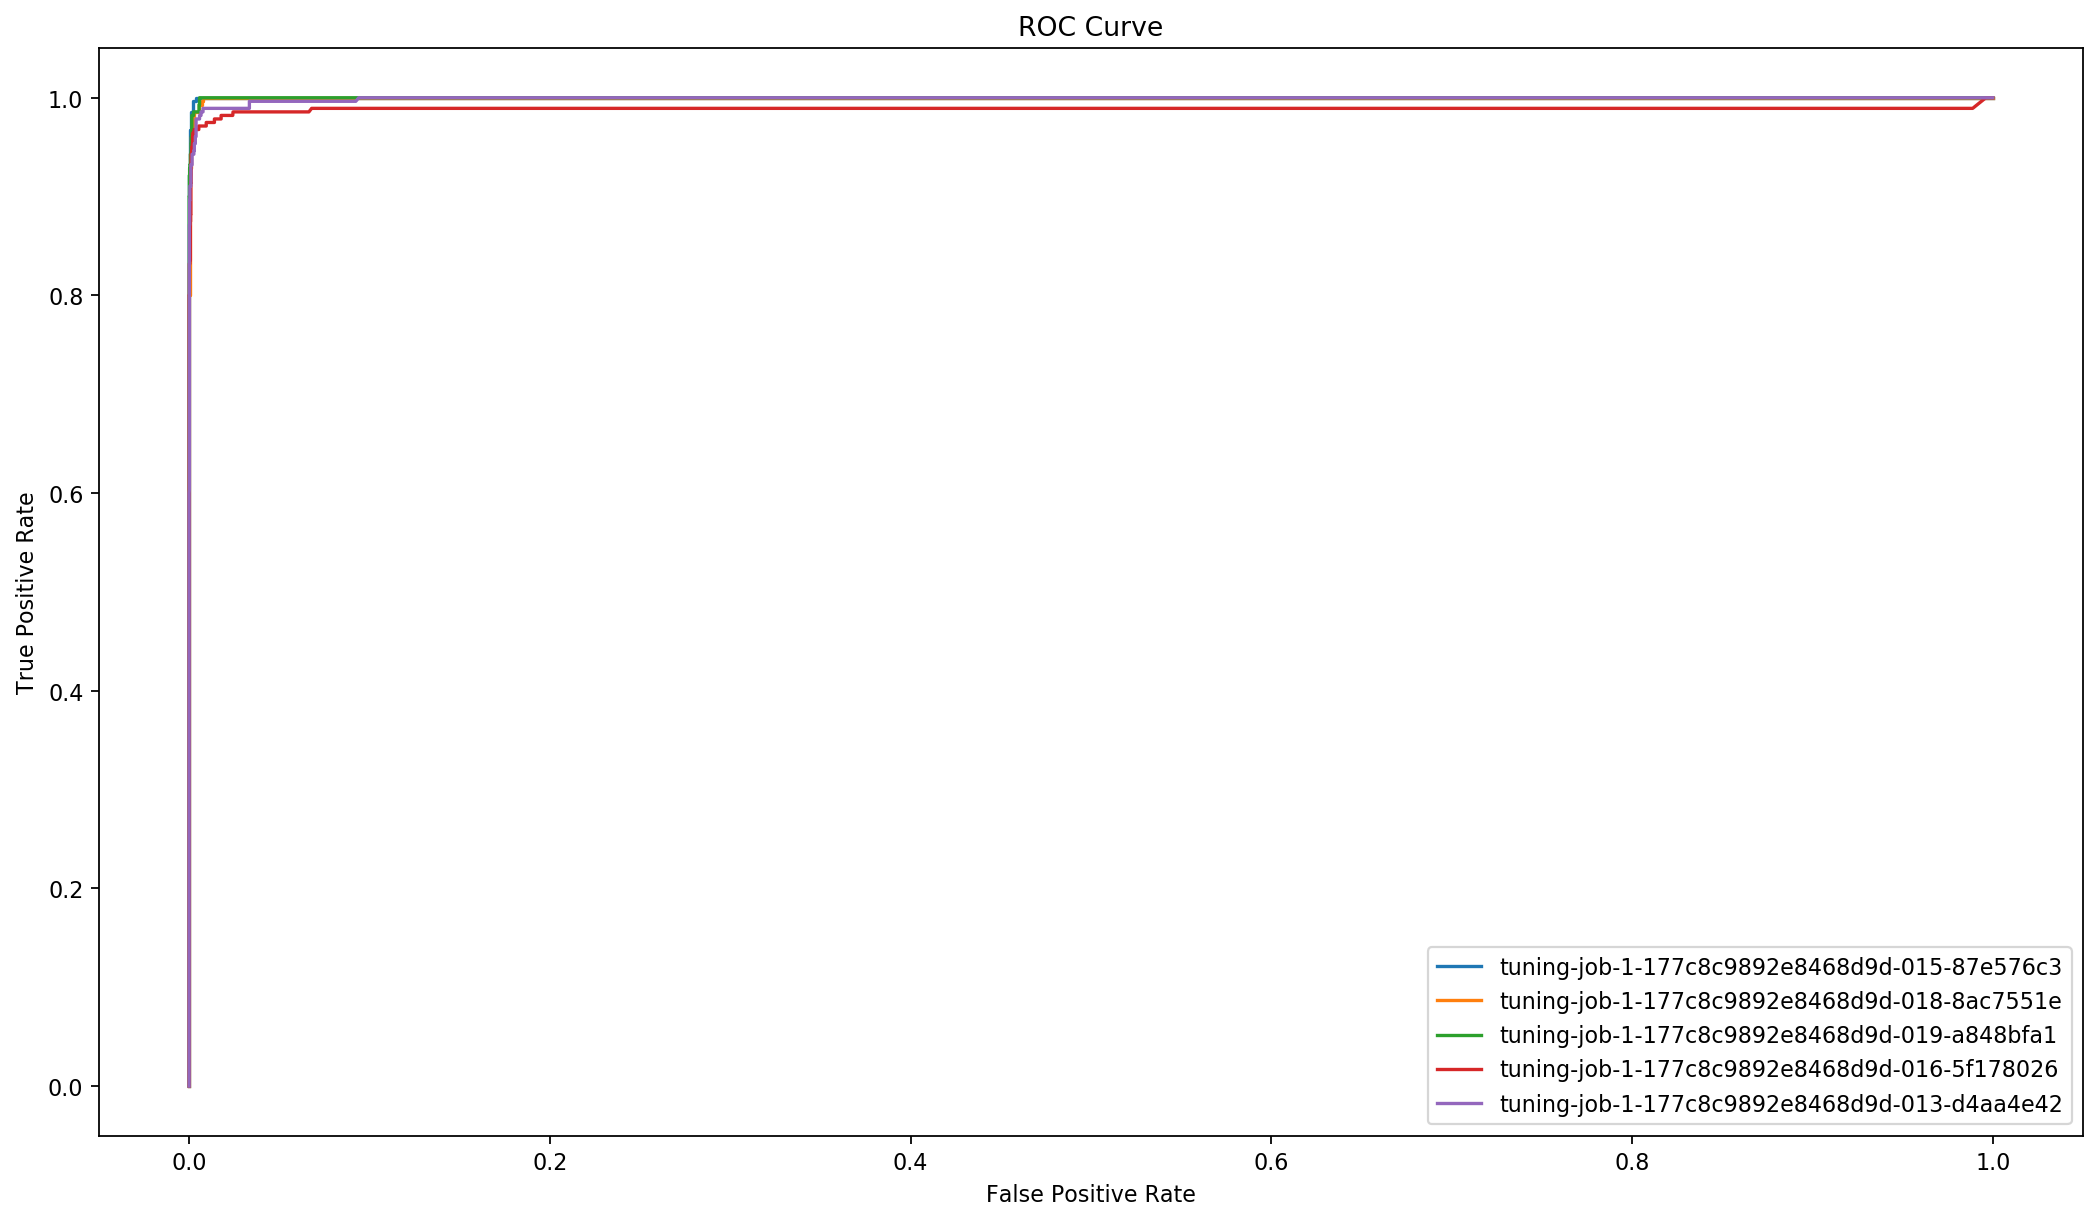

In [39]:
fpr_tpr = []
for prediction in predictions:
    fpr, tpr, _ = roc_curve(labels, prediction.loc[:,1])
    fpr_tpr.append(fpr)
    fpr_tpr.append(tpr)

plt.figure(num=None, figsize=(16, 9), dpi=160, facecolor='w', edgecolor='k')
plt.plot(*fpr_tpr)
plt.legend([candidate['CandidateName'] for candidate in candidates], loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

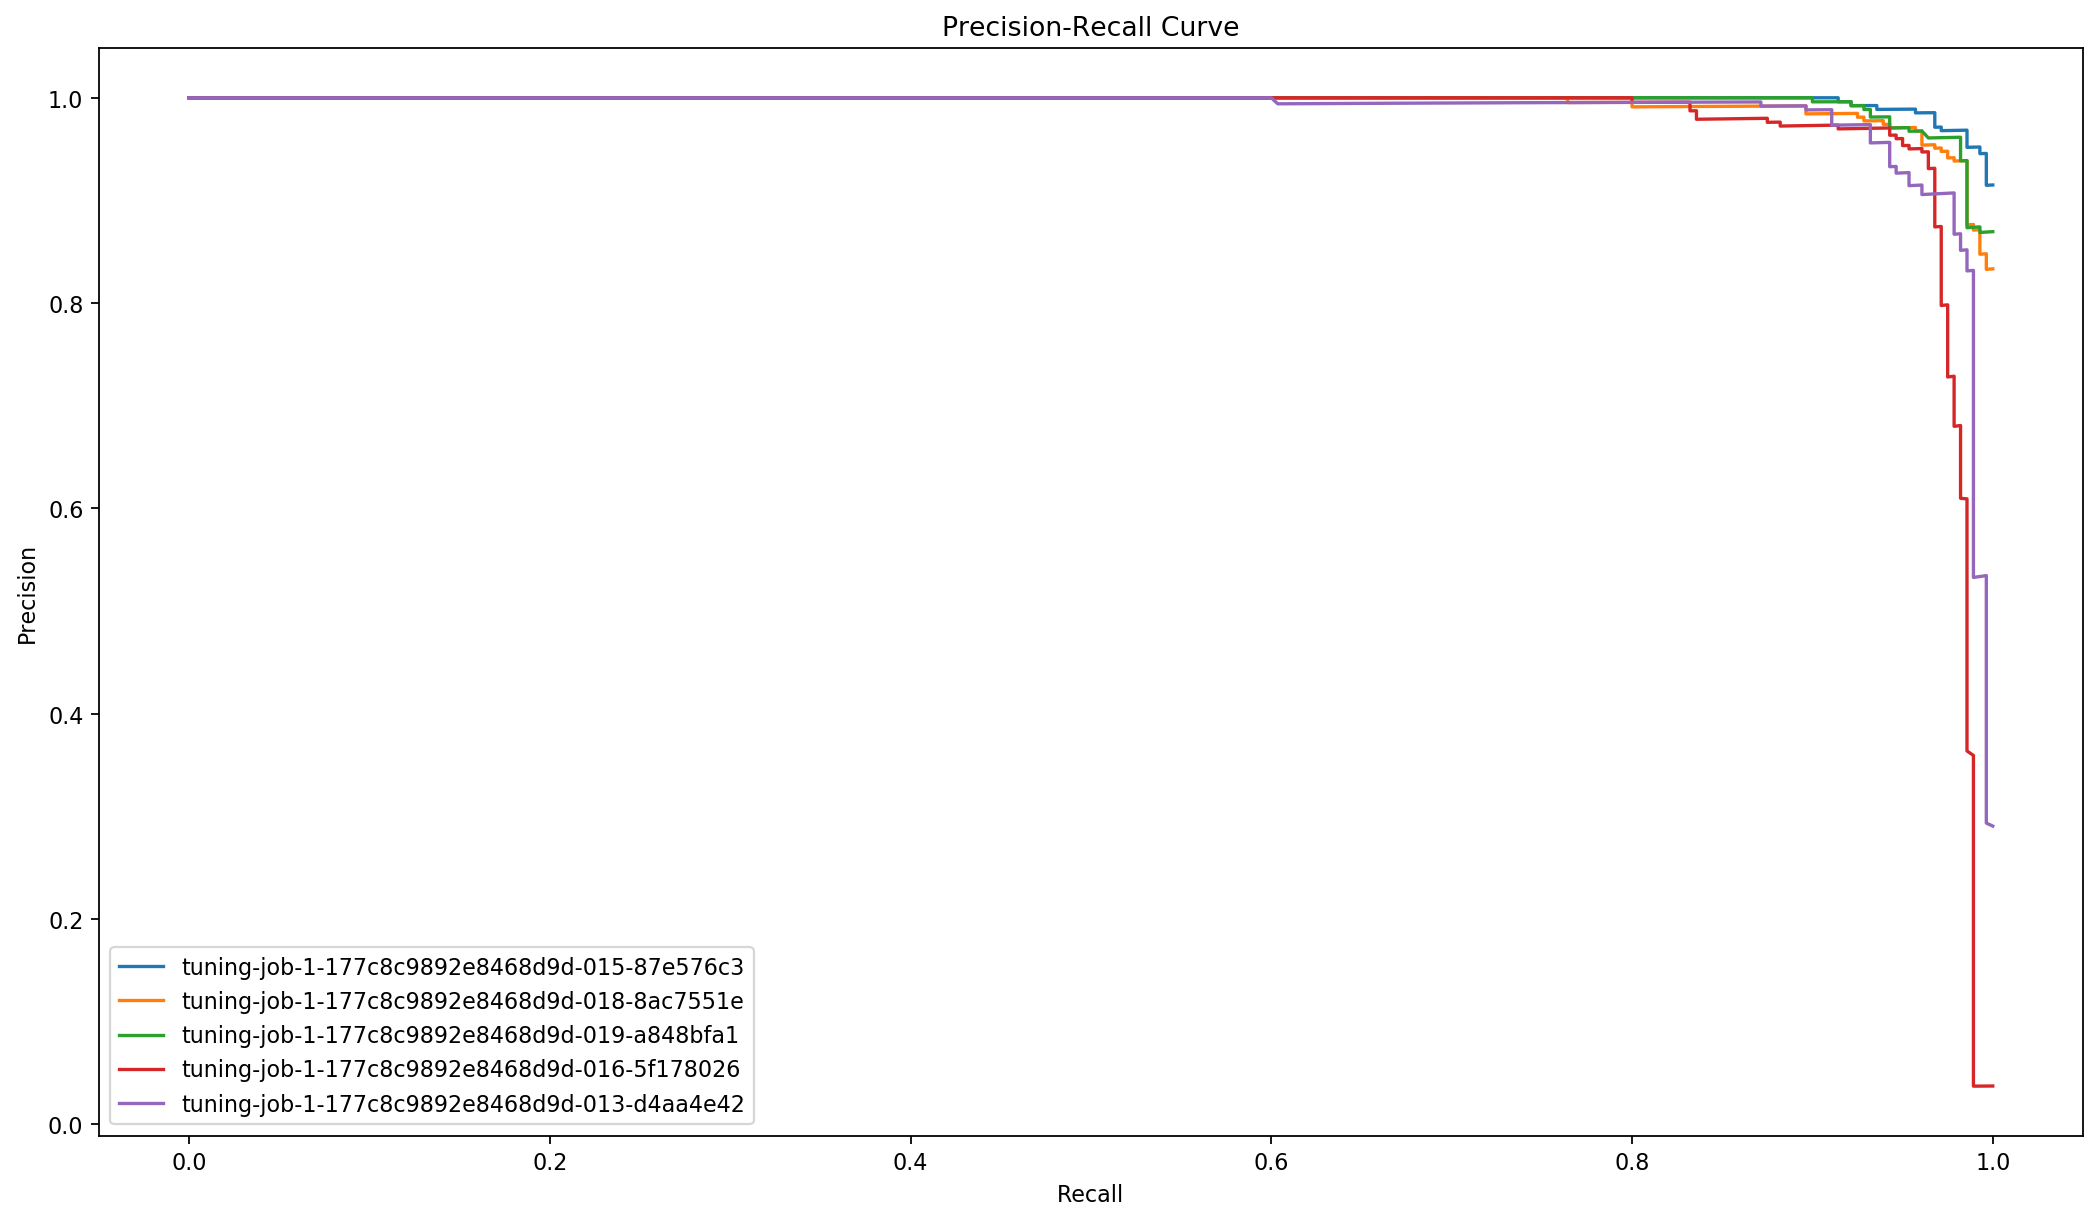

In [40]:
precision_recall = []
for prediction in predictions:
    precision, recall, _ = precision_recall_curve(labels, prediction.loc[:,1])
    precision_recall.append(recall)
    precision_recall.append(precision)

plt.figure(num=None, figsize=(16, 9), dpi=160, facecolor='w', edgecolor='k')
plt.plot(*precision_recall)
plt.legend([candidate['CandidateName'] for candidate in candidates], loc="lower left")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [41]:
target_min_precision = 0.75

best_recall = 0
best_candidate_idx = -1
best_candidate_threshold = -1
candidate_idx = 0
for prediction in predictions:
    precision, recall, thresholds = precision_recall_curve(labels, prediction.loc[:,1])
    threshold_idx = np.argmax(precision>=target_min_precision)
    if recall[threshold_idx] > best_recall:
        best_recall = recall[threshold_idx]
        best_candidate_threshold = thresholds[threshold_idx]
        best_candidate_idx = candidate_idx
    candidate_idx += 1

print("Best Candidate Name: {}".format(candidates[best_candidate_idx]['CandidateName']))
print("Best Candidate Threshold (Operation Point): {}".format(best_candidate_threshold))
print("Best Candidate Recall: {}".format(best_recall))

Best Candidate Name: tuning-job-1-177c8c9892e8468d9d-015-87e576c3
Best Candidate Threshold (Operation Point): 0.0719202533364296
Best Candidate Recall: 1.0


In [42]:
prediction_default = predictions[best_candidate_idx].loc[:,0] == target_attribute_true_value
prediction_updated = predictions[best_candidate_idx].loc[:,1] >= best_candidate_threshold

# compare the updated predictions to Autopilot's default
from sklearn.metrics import precision_score, recall_score
print("Default Operating Point: recall={}, precision={}".format(recall_score(labels, prediction_default), precision_score(labels, prediction_default)))
print("Updated Operating Point: recall={}, precision={}".format(recall_score(labels, prediction_updated), precision_score(labels, prediction_updated)))

Default Operating Point: recall=0.9678571428571429, precision=0.9748201438848921
Updated Operating Point: recall=1.0, precision=0.9150326797385621


In [43]:
## Deploy the selected candidate on an endpoint

inference_response_keys

['predicted_label', 'probability']

In [44]:
from sagemaker.predictor import RealTimePredictor
from sagemaker.content_types import CONTENT_TYPE_CSV

predictor = automl.deploy(initial_instance_count=1,
                          instance_type='ml.m5.xlarge',
                          candidate=candidates[best_candidate_idx],
                          inference_response_keys=inference_response_keys,
                          predictor_cls=RealTimePredictor)
predictor.content_type = CONTENT_TYPE_CSV

print("Created endpoint: {}".format(predictor.endpoint))

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!Created endpoint: sagemaker-sklearn-automl-2020-07-31-13-14-16-376


In [45]:
best_candidate_threshold

0.0719202533364296

In [62]:
## Write test_data removing target 'is_defaulter'

with open('test_data_no_target.csv', 'w') as csv_file:
    test_data_no_target.to_csv(sep=',', header=False, index=False, path_or_buf=csv_file)
    

In [67]:
from io import StringIO

prediction = predictor.predict(test_data_no_target.to_csv(sep=',', header=False, index=False)).decode('utf-8')
prediction_df = pd.read_csv(StringIO(prediction), header=None, names=inference_response_keys)
custom_predicted_labels = prediction_df.iloc[:,1].values >= best_candidate_threshold
prediction_df['custom_predicted_label'] = custom_predicted_labels
prediction_df['custom_predicted_label'] = prediction_df['custom_predicted_label'].map({False: target_attribute_values[0], True: target_attribute_values[1]})
prediction_df

,predicted_label,probability,custom_predicted_label
0,0,1.502011e-05,0
1,0,3.098200e-07,0
2,0,5.432415e-06,0
3,0,1.263015e-05,0
4,0,1.211844e-06,0
...,...,...,...
7548,0,2.715152e-05,0
7549,0,5.919573e-05,0
7550,0,1.623576e-05,0
7551,0,1.649696e-05,0


In [68]:
prediction_df_defaulters = prediction_df[prediction_df["custom_predicted_label"]==1]
prediction_df_defaulters

,predicted_label,probability,custom_predicted_label
51,1,0.852689,1
56,1,0.997500,1
61,1,0.998304,1
72,1,0.999903,1
79,1,0.993855,1
...,...,...,...
7260,1,0.999236,1
7281,0,0.090132,1
7349,1,0.997206,1
7356,1,0.993652,1


In [228]:
cm = confusion_matrix(test_data['is_defaulter'], (predictions[best_candidate_idx].loc[:,0]>0.5))
print('The Confusion Matrix is: \n', cm)
print('TrueNegative   FalsePositive\nFalseNegative   TruePositive\n')

# Calculate the accuracy on test set
predict_accuracy_on_test_set = (cm[0,0] + cm[1,1])/(cm[0,0] + cm[1,1]+cm[1,0] + cm[0,1])
print('The Accuracy on Test Set is: ', predict_accuracy_on_test_set)

The Confusion Matrix is: 
 [[7266    7]
 [   9  271]]
TrueNegative   FalsePositive
FalseNegative   TruePositive

The Accuracy on Test Set is:  0.9978816364358533


As you can see the AutoML provided a way better result for capturing those true positives, and the accuracy on the test set is also higher.

Note Amazon SageMaker Autopilot works with SageMaker pipelines, where it chains different container images in sequence (e.g. Pre-processing container + XGBoost classifier container) for performing the inferences directly with the original data.

In [ ]:
## Cleanup

# s3 = boto3.resource('s3')
# s3_bucket = s3.Bucket(bucket)

# s3_bucket.objects.filter(Prefix=prefix).delete()

# for transformer in transformers:
#     transformer.delete_model()

# predictor.delete_endpoint()
# predictor.delete_model()

## 3. Finally, let's try with Amazon SageMaker built-in XGBoost, but with the same feature selection as per Glovo

Until now, we have seen two methods for working with the example use case provided. Now, let's explore how could we replicate the first case (without AutoML) but using the Amazon SageMaker built-in XGBoost algorithm.

In this case we will just perform the same feature selection as per the first case, but we will consider the hyperparameters of the best candidate on the AutoML example above. It should result on just a slightly better model.

In [9]:
prefix = 'glovo/sandbox/builtin'
data = pd.read_csv('joint_dataframe.csv')
data.head(5)

,courier_id,churn_last_month,registration_date,last_order_time,first_order_time,country_code,city_code,balance_at_that_day_eur,threshold_old,is_defaulter,...,courier__orders_slot_last_7days_over_city_avg_ratio,courier__daily_no_shows_slots_avg_last_week,courier__daily_no_shows_to_booked_slots_ratio_first_week,courier__latenight_slots_booked_count_first_month,courier__delivered_orders_that_belong_to_stores_with_cash_acceptance,courier__credit_acceptance_stores_cancelled_orders,city__stores_with_cash_acceptance_ratio,courier__delivered_orders_that_belong_to_stores_with_credit_acceptance,courier__cash_acceptance_stores_cancelled_orders,courier__assigned_cash_acceptance_store_ratio
0,115561,0,2016-06-10 13:50:12,2020-07-24 09:38:24,2016-06-11 09:23:46,IT,MIL,26.0,179.655,0,...,1.0625,0.0,0.0,2.0,4957.0,257.0,0.839444,8513.0,1202.0,0.540659
1,481059,0,2017-05-05 17:46:36,2020-07-24 11:33:33,2017-05-06 19:39:14,ES,SEV,100.0,181.965,0,...,1.1333,0.0,0.0,0.0,4183.0,204.0,0.328922,9187.0,824.0,0.446024
2,512784,0,2017-05-22 15:28:20,2020-07-24 11:49:24,2017-05-25 10:04:50,IT,MIL,42.0,179.655,0,...,1.5000,0.0,0.0,0.0,5681.0,135.0,0.839444,8593.0,564.0,0.646496
3,601705,0,2017-06-22 15:29:58,2020-07-24 11:37:21,2017-06-25 10:02:10,IT,MIL,106.0,179.655,0,...,1.1250,0.0,0.0,0.0,1292.0,44.0,0.839444,2828.0,49.0,0.447927
4,623940,0,2017-06-29 07:54:01,2020-06-27 21:39:40,2017-07-02 10:18:59,IT,MIL,42.0,179.655,0,...,0.9375,0.0,0.0,0.0,2619.0,83.0,0.839444,4223.0,482.0,0.625691


In [10]:
cols = [0, 1, 2, 3, 4, 5, 6, 8, 56, 191, 201, 203, 206, 209, 218, 220]
data.drop(data.columns[cols],axis=1,inplace=True)
#data.head(5)

In [11]:
import os

data = pd.concat([data['is_defaulter'], data.drop(['is_defaulter'], axis=1)], axis=1) 

train_data, validation_data, test_data = np.split(data.sample(frac=1, random_state=1729), [int(0.7 * len(data)), int(0.95 * len(data))])
train_data.to_csv('train-built.csv', header=False, index=False)
validation_data.to_csv('validation-built.csv', header=False, index=False)
test_data.to_csv('test_real-built.csv', header=False, index=False)
test_data.drop(['is_defaulter'], axis=1).to_csv('test-built.csv', header=False, index=False)

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train-built.csv')).upload_file('train-built.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation-built.csv')).upload_file('validation-built.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test-built.csv')).upload_file('test-built.csv')

In [16]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation'.format(bucket, prefix), content_type='csv')
s3_input_test = sagemaker.s3_input(s3_data='s3://{}/{}/test'.format(bucket, prefix), content_type='csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


Now, with the split data in S3 and ready for training, we will setup an Amazon SageMaker XGBoost training job.

In [ ]:
containers = {'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'}

xgbb = sagemaker.estimator.Estimator(containers[region],
                                    role,
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=session)
xgbb.set_hyperparameters(objective='binary:logistic',
                         alpha = 0.0017958870152480393,
                         colsample_bytree = 0.8974444697232986,
                         eta = 0.378416419404957,
                         gamma = 0.0038479366336815115,
                         max_depth = 22,
                         min_child_weight = 3.4445863514152535,
                         num_round = 139,
                         subsample = 0.7432022124726009
                        )

Let's train this model.

In [38]:
xgbb.fit({'train': s3_input_train, 'validation': s3_input_validation})

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-08-03 22:36:48 Starting - Starting the training job...
2020-08-03 22:36:50 Starting - Launching requested ML instances......
2020-08-03 22:37:54 Starting - Preparing the instances for training......
2020-08-03 22:38:52 Downloading - Downloading input data...
2020-08-03 22:39:43 Training - Training image download completed. Training in progress..Arguments: train
[2020-08-03:22:39:44:INFO] Running standalone xgboost training.
[2020-08-03:22:39:44:INFO] File size need to be processed in the node: 68.16mb. Available memory size in the node: 8476.13mb
[2020-08-03:22:39:44:INFO] Determined delimiter of CSV input is ','
[22:39:44] S3DistributionType set as FullyReplicated
[22:39:44] 26436x323 matrix with 8538788 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-08-03:22:39:44:INFO] Determined delimiter of CSV input is ','
[22:39:44] S3DistributionType set as FullyReplicated
[22:39:44] 9441x323 matrix with 3049434 entries loaded from /opt/ml/input/da

After a few seconds we are ready to deploy this model on an endpoint for inference.

In [39]:
xgbb_predictor = xgbb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!

Let's run the test data inferences on the endpoint, and evaluate the model.

In [40]:
xgbb_predictor.content_type = 'text/csv'
xgbb_predictor.serializer = csv_serializer
xgbb_predictor.deserializer = None

def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgbb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

In [41]:
test_data_no_target = test_data.drop(test_data.columns[0],axis=1)
#test_data_no_target.head(5)

In [42]:
#test_data.head(5)

In [43]:
predsb = predict(test_data_no_target.values)
predsb

array([2.36184551e-05, 1.29825503e-06, 1.30792330e-06, ...,
       1.07227579e-05, 7.44015495e-07, 1.55527800e-07])

In [44]:
Y_testb = test_data.values[:,0]
print(Y_testb)

[0. 0. 0. ... 0. 0. 0.]


In [45]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

best_predsb = np.asarray([np.argmax(line) for line in predsb])

print("Precision = {}".format(precision_score(Y_testb, best_predsb, average='macro')))
print("Recall = {}".format(recall_score(Y_testb, best_predsb, average='macro')))
print("Accuracy = {}".format(accuracy_score(Y_testb, best_predsb)))

Precision = 0.47776601376389627
Recall = 0.5
Accuracy = 0.9555320275277925


In [46]:
cmb = confusion_matrix(Y_testb, (predsb>0.5))
print('The Confusion Matrix is: \n', cmb)
print('TrueNegative   FalsePositive\nFalseNegative   TruePositive\n')

# Calculate the accuracy on test set
predict_accuracy_on_test_setb = (cmb[0,0] + cmb[1,1])/(cmb[0,0] + cmb[1,1]+cmb[1,0] + cmb[0,1])
print('The Accuracy on Test Set is: ', predict_accuracy_on_test_setb)

The Confusion Matrix is: 
 [[1792   13]
 [  30   54]]
TrueNegative   FalsePositive
FalseNegative   TruePositive

The Accuracy on Test Set is:  0.9772366331392272


As expected, this model is a bit better than our first case, but still worse than our second case.

In the next lab, we will learn how to industrialize/automate one of these examples following AWS MLOps best practices. We will choose this third case for simplicity and saving time, but note we could also use the AutoML artifacts from the second case if we want to.